In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torchvision
from tqdm import tqdm_notebook
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import pdb

%matplotlib inline

In [85]:
import warnings
warnings.filterwarnings('ignore')

## Loading MNIST dataset

In [86]:
batch_size = 20

In [87]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

In [88]:
trainloader.dataset.train_data.shape, testloader.dataset.test_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [114]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

class_names = tuple(str(i) for i in range(10))

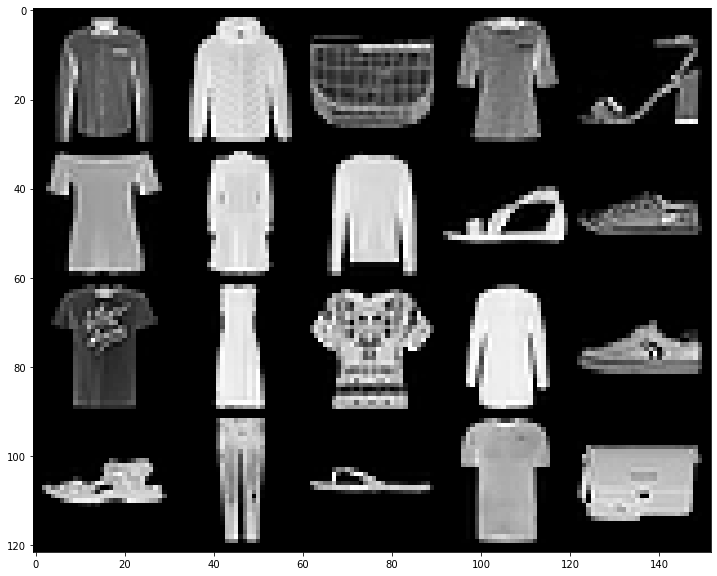

In [115]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(15,10))
imshow(torchvision.utils.make_grid(images, nrow=batch_size//4))
plt.show()

In [116]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [117]:
device

'cuda:0'

## Model parameters

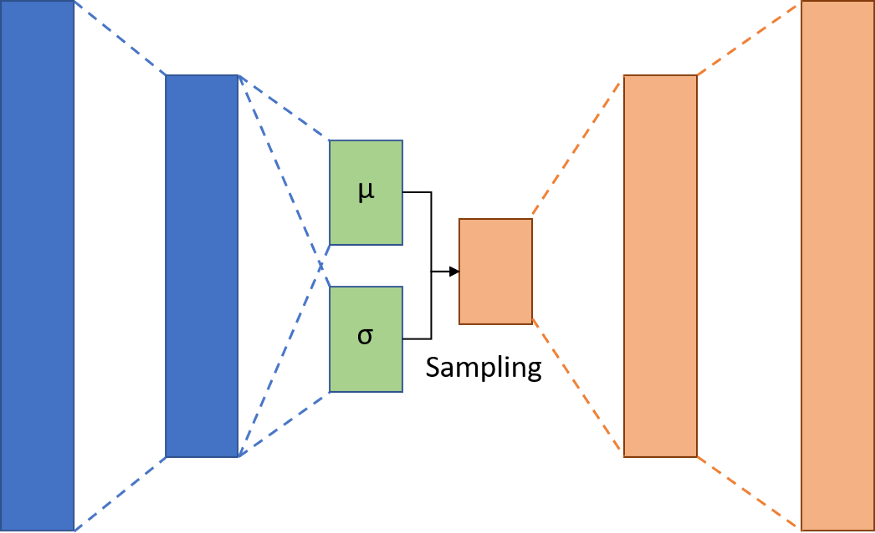

In [118]:
class VAE(nn.Module):
    def __init__(self, beta=1):
        super(VAE, self).__init__()
        self.hidden_size = 28
        self.encoder = nn.Sequential(nn.Flatten(),
                                     nn.Linear(784,392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
                                     nn.Linear(392, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
                                     nn.Linear(196, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
                                     nn.Linear(128, self.hidden_size))
        
        self.hidden_mu = nn.Linear(self.hidden_size, self.hidden_size)
        self.hidden_log_var = nn.Linear(self.hidden_size, self.hidden_size)
        
        self.decoder = nn.Sequential(nn.Linear(self.hidden_size, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
                                     nn.Linear(128, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
                                     nn.Linear(196, 392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
                                     nn.Linear(392, 784),
                                     #nn.Unflatten(),
                                     #reshape back to 28,28
                                     nn.Sigmoid())
        self.beta = beta # in case of disentangled VAE !=1 and is passed as a parameter
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden_mu(hidden)
        log_var = self.hidden_log_var(hidden) # getting mu and sigma for reparametrization trick
        return mu, log_var

    def reparametrize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        #z = std_normal.sample((sigma.size[0],self.hidden_size)) # TODO: fix the sample shape
        z = torch.randn_like(sigma) # get normal distribution size of sigma
        return sigma * z + mu
    
    def decode(self, x):
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        hidden = self.reparametrize(mu, log_var) # bottleneck
        output = self.decoder(hidden) # x_out
        return mu, log_var, output 

### Loss function

In [119]:
def loss_fn(mu, log_var, x_out, x):
        kl_loss = (-0.5*( 1 + log_var - mu**2 - torch.exp(log_var)).sum(1)).mean(0)
        #recon_loss = std_normal.log_prob(x_out).sum(1).mean()/batch_size # x_out = z
        #recon_loss = self.distrN(mu, log_var).log_prob(x).sum(1).mean()/batch_size
        recon_loss_criterion = nn.MSELoss()
        recon_loss = recon_loss_criterion(x, x_out)
        loss = recon_loss + kl_loss
        return loss

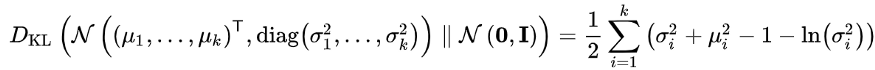

## Training

In [120]:
net = VAE()

In [121]:
optimizer = torch.optim.Adagrad(params = net.parameters())
#optimizer = torch.optim.Adam(params = net.parameters())
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

In [122]:
train_loss=[]
test_loss = []
net.train(True)
for i, batch in enumerate(tqdm_notebook(trainloader)):   
    optimizer.zero_grad()

    x, _ = batch
    mu, log_var, x_out = net.forward(x)
    
    loss = loss_fn(mu, log_var, x_out.view((batch_size,28,28)), x)
    
    loss.backward()
    optimizer.step()

    train_loss.append(loss.detach().item())
    
    #net.train(False)
    #with torch.no_grad():
       # mu, log_var, x_out = net.forward(x)
       # test_loss.append(loss_fn(mu, log_var, x_out.reshape((batch_size,28,28)),x).item())

  0%|          | 0/3000 [00:00<?, ?it/s]

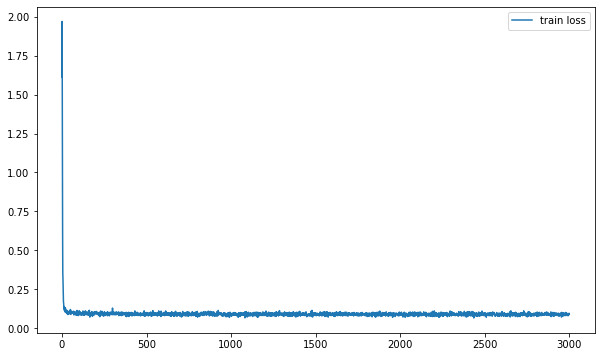

In [123]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(train_loss)), train_loss, label="train loss")
#plt.plot(np.arange(len(test_loss)), test_loss, label="test loss")
#plt.title("Losses")
#plt.ylim(0,1)
plt.legend()
plt.show()

## Testing

In [124]:
net.train(False)
for i, batch in enumerate(tqdm_notebook(testloader)):    
    with torch.no_grad():
        x, _ = batch
        mu, log_var, x_out = net.forward(x)
        loss = loss_fn(mu, log_var, x_out.reshape((batch_size,28,28)), x)

        test_loss.append(loss.detach().item())

  0%|          | 0/500 [00:00<?, ?it/s]

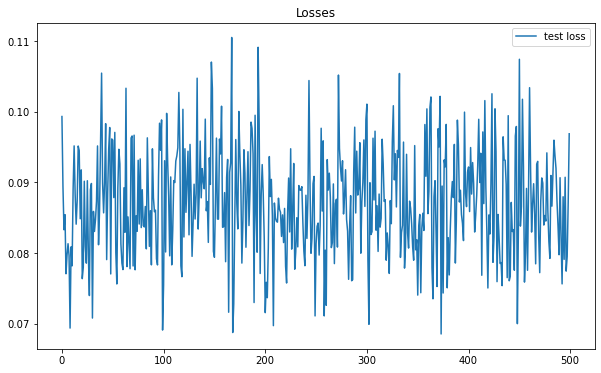

In [125]:
plt.figure(figsize=(10,6))
#plt.plot(np.arange(len(train_loss)), train_loss, label="train loss")
plt.plot(np.arange(len(test_loss)), test_loss, label="test loss")
plt.title("Losses")
#plt.ylim(0,1)
plt.legend()
plt.show()

In [126]:
# def imcheck(data, shape=(20,5)):
#     columns = shape[1]
#     rows = shape[0]
#     fig = plt.figure(figsize=(rows*4, columns*2))    
#     ax = []

#     for i in range(columns*rows):
#         img = x_out[i].detach().reshape((28,28)).numpy()
#         ax.append( fig.add_subplot(rows, columns, i+1) )
#         ax[-1].set_title("ax:"+str(i))
#         plt.imshow(img, cmap='gray')

#     plt.show()

In [127]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [128]:
with torch.no_grad():
    _, __, x_out = net.forward(images)

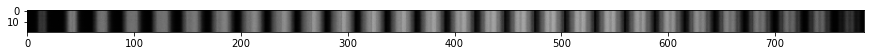

In [129]:
plt.figure(figsize=(15,10))
imshow(torchvision.utils.make_grid(x_out, nrow=20))
plt.show()

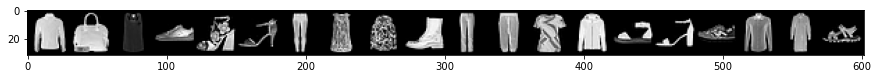

In [130]:
plt.figure(figsize=(15,10))
imshow(torchvision.utils.make_grid(images, nrow=20))
plt.show()

## Simple Autoencoder

In [141]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
#         self.encoder = nn.Linear(784, encoding_dim)
#         self.decoder = nn.Linear(encoding_dim, 784)
        self.encoder = nn.Sequential(nn.Linear(784,392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
                                     nn.Linear(392, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
                                     nn.Linear(196, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
                                     nn.Linear(128, encoding_dim))
        
        self.decoder = nn.Sequential(nn.Linear(encoding_dim, 128), nn.BatchNorm1d(128), nn.LeakyReLU(0.1),
                                     nn.Linear(128, 196), nn.BatchNorm1d(196), nn.LeakyReLU(0.1),
                                     nn.Linear(196, 392), nn.BatchNorm1d(392), nn.LeakyReLU(0.1),
                                     nn.Linear(392, 784))

    def forward(self, x):
        x = F.relu(self.encoder(x))
        x = F.sigmoid(self.decoder(x))
        return x

# initialize the NN
encoding_dim = 64
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=392, out_features=196, bias=True)
    (4): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=196, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1)
    (9): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=128, out_features=196, bias=True)
    (4): BatchNorm1d(196, eps=1e-05, momentum=0

In [142]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

In [143]:
n_epochs = 20

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    for data in tqdm_notebook(trainloader):
        images, _ = data
        images = images.view(images.size(0), -1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    lr_scheduler.step()
    train_loss = train_loss/len(trainloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.472865


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.363247


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.329569


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.308983


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.294823


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.283713


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.274784


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.268497


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.262421


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.256391


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.251711


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.248780


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.244842


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.240838


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.237570


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.234827


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.232646


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.229858


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.228001


  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.224912


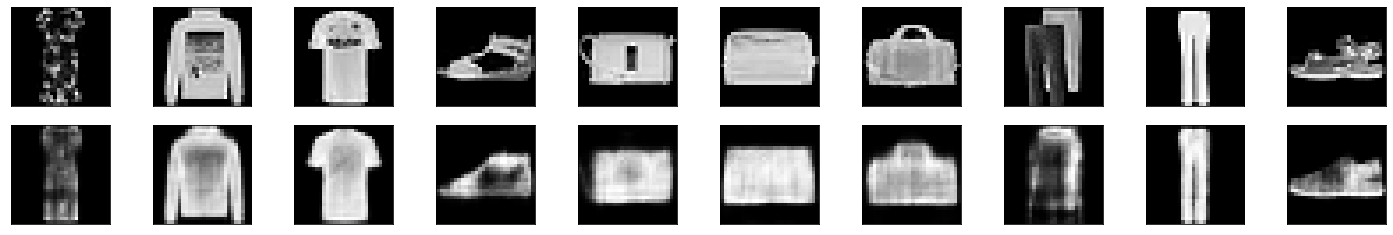

In [144]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
output = model(images_flatten)
images = images.numpy()

output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)